# Notebook objective

This notebook's objective is to explore the dataset provided by the Whereismytransport team, in order to understand how to use this to complete the exercise.

Assessment source: https://drive.google.com/drive/folders/1akT7jbXYy2-zLHEtnK3q6vqcQ-JdRO9H

# Preparation

## Import required libraries

In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns

## Folder structure

In [2]:
# Make root folder the current working directory
os.chdir('..')

In [3]:
input_folder = './data/raw/'

In [4]:
output_folder = './reports/figures/'

## Data import

In [5]:
alerts_df = pd.read_csv(input_folder + 'alerts.csv')
alerts_df.head(2)

,Unnamed: 0,document_id,published_at,description
0,0,-MUH7_dRaJMkhnxY9bHs,2021-02-24 03:58:39+00:00,🔥 Considera retrasos por servicios de emergenc...
1,1,-MUH7_dRaJMkhnxY9bHs,2021-02-24 03:58:39+00:00,🔥 Considera retrasos por servicios de emergenc...


In [6]:
dateparse = lambda x: datetime.strptime(x, '%Y%m%d')

notifications_df = pd.read_csv(input_folder + 'notfications.csv', parse_dates=['event_date'])
notifications_df.head(2)

,Unnamed: 0,event_date,event_timestamp,event_name,user_id,join_key_value
0,0,2021-05-29,1622251203899000,notification_receive,283a1,-Maph6wn8GA3SjPIc9HA
1,1,2021-05-29,1622257988561000,notification_receive,283a1,-Maq63vqDUxQRawQ_3Au


# Exploratory analysis

## alerts

In [7]:
# Calculate the missing data % in training data
missing_data = alerts_df.isna().sum() / alerts_df.isna().count() * 100
missing_data[missing_data > 0].sort_values(ascending=False)

published_at    0.465219
dtype: float64

In [8]:
alerts_df[alerts_df['published_at'].isnull()]

,Unnamed: 0,document_id,published_at,description
420,420,-MTHuWtahAzCEWyyI1Cz,NaN,¿Traes tus flotis? Hay retrasos por inundació...
699,699,-MUZXpCUVuYnegdiLDm4,NaN,✋ ¡Ahí te van! Inicia marcha sobre Calz. San A...
838,838,-MTxAbQHE7RyjCmVaWYO,NaN,⏳ ¡Tómalo en cuenta! Retrasos por servicios de...
839,839,-MTxAbQHE7RyjCmVaWYO,NaN,⏳ ¡Tómalo en cuenta! Retrasos por servicios de...
1072,1072,-MSjp1mUtZ3Ndpm4sRTe,NaN,⌚ Échate una leída en el blog de Rumbo porque ...
...,...,...,...,...
12463,12463,-MRWq-R8SVXcuedAbmfL,NaN,¡Ojo! Retrasos por percance en Anillo Periféri...
12518,12518,-M_Xq4NAj7NKEIVWY5tk,NaN,⏳ ¡Tómalo en cuenta! Retrasos por accidente ve...
12857,12857,-MZmuavfdU8ig8nqaT7J,NaN,⏳ ¡Híjole! Hay retrasos por accidente vehicula...
13379,13379,-MQm7dFboX-pa_uUZFgX,NaN,⏳ ¡No de nuevo! Hay retrasos por accidente veh...


The data shows that the column 'published_at' is missing 0.47% of values. Considering the small sample without these values, I will likely drop them from this analysis. 

If the objective of this exercise was to create a system that can be applied to customers, I would've recommended an internal investigation to find out why those values are missing.

<AxesSubplot:>

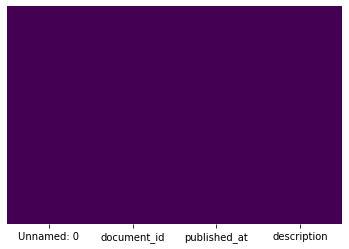

In [9]:
# Visualise missing data
sns.heatmap(alerts_df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [10]:
alerts_df.dtypes

Unnamed: 0       int64
document_id     object
published_at    object
description     object
dtype: object

In [11]:
alerts_df['document_id'].nunique()

8564

Based on how the data looks, document_id is the unique message identifier. Based on this assumption, there are 8564 unique messages.

In [12]:
alerts_df['description'].nunique()

8518

Interestingly, when looking at the messages, there are only 8515 unique messages. This could mean that there are 46 message ids with a non-unique message. 

In [13]:
dups_df = alerts_df[['document_id', 'description']].copy()
# concatenate messages and id
dups_df['concat'] = dups_df['document_id'] + dups_df['description']
# keep unique combinations
dups_df = dups_df[dups_df.duplicated(subset='concat', keep='first')]
# Select most occuring message as example
most_occuring = dups_df['description'].value_counts().index.tolist()[0]
dups_df[dups_df['description'] == most_occuring][['document_id', 'description']]

,document_id,description
4973,-MZD8SnnjmMRmchr-w3t,✋ ¡Así como lo lees! Continúa el cierre de cir...
4974,-MZD8SnnjmMRmchr-w3t,✋ ¡Así como lo lees! Continúa el cierre de cir...
5642,-MZwcDQXFr02iP0BsTrR,✋ ¡Así como lo lees! Continúa el cierre de cir...
5692,-MYimvCb8mgUawkL6DPP,✋ ¡Así como lo lees! Continúa el cierre de cir...
5720,-M_Q5tEjGtFwVBNcqzHX,✋ ¡Así como lo lees! Continúa el cierre de cir...


There are quite a few duplicate messages with different document_id. Depending on the required outcome, it may be useful to recode the document id into unique values.

In [14]:
alerts_df['published_at'].describe()

count                         13479
unique                         8522
top       2021-05-08 16:26:10+00:00
freq                              5
Name: published_at, dtype: object

The datetime field is not in a format that is easy for Python to recognise and currently considered a string type. For Python to recognise the column as a date field, a data transformation needs to happen.

In [15]:
# Make date field a pandas date type
alerts_df['published_at'] = alerts_df['published_at'].str[:19]
alerts_df['published_at'] = pd.to_datetime(alerts_df['published_at'])
alerts_df['published_at']

0       2021-02-24 03:58:39
1       2021-02-24 03:58:39
2       2021-03-31 22:54:19
3       2021-03-31 22:54:19
4       2021-03-31 22:54:19
                ...        
13537   2021-04-30 21:32:24
13538   2021-05-04 00:52:21
13539   2021-03-26 14:44:15
13540   2021-01-27 17:51:51
13541   2021-06-25 11:25:49
Name: published_at, Length: 13542, dtype: datetime64[ns]

In [16]:
# Describe the date field
alerts_df['published_at'].describe()

C:\Users\michiel.HEPSTAR\AppData\Local\Continuum\anaconda3a\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


count                   13479
unique                   8522
top       2021-05-08 16:26:10
freq                        5
first     2021-01-01 00:25:10
last      2021-07-07 03:58:40
Name: published_at, dtype: object

Looking at the datetime column, the data in this dataset contains six months, from Jan 1st until July 7th 2021.

# Data exploration

In [17]:
notifications_df.head()

,Unnamed: 0,event_date,event_timestamp,event_name,user_id,join_key_value
0,0,2021-05-29,1622251203899000,notification_receive,283a1,-Maph6wn8GA3SjPIc9HA
1,1,2021-05-29,1622257988561000,notification_receive,283a1,-Maq63vqDUxQRawQ_3Au
2,2,2021-05-29,1622258235184001,notification_receive,283a1,-Maq7-D7bhcEaFBU1LDW
3,3,2021-05-29,1622260301025000,notification_receive,283a1,-MaqEsbKAqlxGG-RupjR
4,4,2021-05-29,1622293962198000,notification_receive,283a1,-MasFHCt_lTuNt_x16dH


Having a quick look at this dataset shows that it contains data on actions which took place after the message was sent. This table can likely be joined with the 'join_key_value' column.

In [18]:
notifications_df.shape

(2278151, 6)

The dataste contains 6 columns and ~2.3 million rows.

In [19]:
# Calculate the missing data % in training data
missing_data = notifications_df.isna().sum() / notifications_df.isna().count() * 100
missing_data[missing_data > 0].sort_values(ascending=False)

join_key_value    0.021245
dtype: float64

In [20]:
notifications_df[notifications_df['join_key_value'].isnull()]

,Unnamed: 0,event_date,event_timestamp,event_name,user_id,join_key_value
257,257,2021-05-29,1622258577858000,notification_opened,e8300,NaN
597,597,2021-05-29,1622254709611002,notification_opened,496f0,NaN
2036,2036,2021-05-29,1622254194462000,notification_opened,b28d8,NaN
6967,6967,2021-05-29,1622252667142002,notification_opened,cabbc,NaN
6972,6972,2021-05-29,1622295005683000,notification_opened,cabbc,NaN
...,...,...,...,...,...,...
2203079,2203079,2021-06-30,1625060955781006,notification_view_alternatives,b2f91,NaN
2207594,2207594,2021-06-30,1625015183970000,notification_opened,3e06f,NaN
2207605,2207605,2021-06-30,1625022975179003,notification_opened,3e06f,NaN
2207610,2207610,2021-06-30,1625048595336000,notification_opened,3e06f,NaN


This data shows that the column 'join_key_value' is missing 2% of values. Considering the small sample without these values, I will likely drop them from this analysis. 

If the objective of this exercise would be to create a system that can be applied to customers, I would've recommended an internal investigation to find out why those values are missing.

<AxesSubplot:>

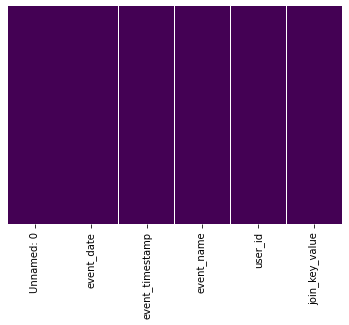

In [21]:
# Visualise missing data
sns.heatmap(notifications_df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [22]:
notifications_df['event_date'].describe()

C:\Users\michiel.HEPSTAR\AppData\Local\Continuum\anaconda3a\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                 2278151
unique                    189
top       2021-03-26 00:00:00
freq                    25531
first     2021-01-01 00:00:00
last      2021-07-08 00:00:00
Name: event_date, dtype: object

This dataset contains one more day than the alerts dataset (2021-07-08). This will likely be useful, as it may take some time for customers to take any action on the message they receive.

In [23]:
# Recode similar event names
notifications_df['event_name'].replace('notification_received',
                                       'notification_receive', inplace=True)
notifications_df['event_name'].replace('notification_opened',
                                       'notification_open', inplace=True)

In [24]:
notifications_df['event_name'].value_counts()

notification_receive              1353372
notification_dismiss               884049
notification_open                   40049
notification_share                    523
notification_view_alternatives        158
Name: event_name, dtype: int64

Looking at the event type column, there are quite a few similar events. According to the exercise description, similar exercises can be combined.

In [25]:
notifications_df['event_name'].value_counts()

notification_receive              1353372
notification_dismiss               884049
notification_open                   40049
notification_share                    523
notification_view_alternatives        158
Name: event_name, dtype: int64

After recoding, we can see 5 types of notifications. The receive notification is the most common category, which makes sense as most users will receive a message.

Also, not all users who received a notification have any follow-up event. Some users may not have interacted based on the message they received or they may not have received any messages.

Looking at the notifications per user, 8ac62 is the most active one with 5750 notifications.

In [26]:
notifications_df[notifications_df['user_id'] == '8ac62']['event_name'].value_counts()

notification_receive    2951
notification_dismiss    2747
notification_open         52
Name: event_name, dtype: int64

When looking at the notifications for that user, interestingly only 52 messages were opened and most were dismissed (93%).

# Next

Now that we have a fairly good idea on which data this dataset contains, the next step is to create the customer segments as per the requirements.